In [96]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import os
import cv2 as cv
sns.set_theme()
plt.rcParams['figure.figsize'] = [14,8]

In [97]:
CYCLIC_COLUMNS = ["PSVTime", "PSV", "PDVTime", "PDV", "EDVTime", "EDV", "ISVTime", "ISV", "MBF1", "MBF2", "SysTime", "DiasTime", "OSI", "WindowTime"]
TIME_SERIES_COLUMNS = ["Time","BloodFlow","Filtered Blood Flow", "Shear", "Filtered Shear", "Velocity", "Diameter"]
ANALYSIS_SETTINGS_COLUMNS = ["Peak Height Threshold", "Cycle Duration", "Peak Count", "EpochEndTime", "Velocity Calibration", "Time Calibration", "Distance Calibration", "Zero Velocity Row Position"]

In [98]:
def subj_file(subj_str: str, trial_type: str, data_type: str):
    folder = f"bloodflow_data/{subj_str}"
    filename = None
    files = None
    
    if trial_type in ['baseline', 'base', 'basline']:
        files = [file_name for file_name in os.listdir(folder) if 'baseline' in file_name or 'basline' in file_name or 'base' in file_name]

    elif trial_type in ['post-oc', 'post-occ', 'post-occlusion', 'post']:
        files = [file_name for file_name in os.listdir(folder) if 'post' in file_name]

    else:
        raise ValueError(f"{trial_type} is not an acceptable parameter for trial_type")
    
    if data_type in ['diameter', 'diam']:
        files = [file_name for file_name in files if 'diam' in file_name]
        filename = files[0][:-4]
    elif data_type in ['time', 'time_series', 'time series', 'cyclic'] :
        files = [file_name for file_name in files if 'flow' in file_name or 'doppler' in file_name]
        filename = files[0][:str.index(files[0], '_')]
        
    else:
        raise ValueError(f"{data_type} is not an acceptable parameter for data_type")
    
    return f"{folder}/{filename}", data_type

In [99]:
def load(file):
    data = pd.DataFrame()
    if file[1] in ['diameter', 'diam']:
        data['diameter'] = np.load(f"{file[0]}.npy")['diameters']
        data['diameter'] *= np.load(f"{file[0]}.npy")['px_to_cm']
        
    elif file[1] == 'cyclic':
        data = pd.read_csv(f"{file[0]}_cyclic.csv", header = None)
        data.columns = CYCLIC_COLUMNS
        
    elif file[1] in ['time', 'time_series', 'time series']:
        data = pd.read_csv(f"{file[0]}_time_series.csv", header = None)
        data.columns = TIME_SERIES_COLUMNS
    
    return data

In [100]:
def interpolate(array):
    arr = array.copy()

    nan_indices = np.isnan(arr)

    if not np.any(nan_indices):
        return array
    
    valid_indices = np.arange(len(arr))[~nan_indices]
    valid_values = arr[~nan_indices]

    spline = sp.interpolate.UnivariateSpline(valid_indices, valid_values, s=0)

    # Interpolate NaN values using the fitted spline
    arr[np.flatnonzero(nan_indices)] = spline(np.flatnonzero(nan_indices))

    return arr

In [101]:
def filter_diameter(diameter_series: pd.Series, cutoff_frame=False, apply_median_filter=False):

    # print(f"Percent NaN before filtering: {diameter_series.isna().sum() / len(diameter_series) * 100}%")
    
    diameter_array = diameter_series.to_numpy().squeeze()
    
    # Interpolate NaN values
    interpolated_diameter = interpolate(diameter_array.copy())
    
    # Low-pass and high-pass filter parameters
    low_pass_cutoff_frequency = 0.05
    filter_order = 2
    
    # Apply low-pass filter
    lowpass_filter = sp.signal.butter(filter_order, low_pass_cutoff_frequency, 'lowpass', output='sos')
    lowpass_filtered = sp.signal.sosfilt(lowpass_filter, interpolated_diameter)
    
    # Apply high-pass filter
    highpass_filter = sp.signal.butter(filter_order, low_pass_cutoff_frequency, 'highpass', output='sos')
    highpass_filtered = sp.signal.sosfilt(highpass_filter, interpolated_diameter)
    
    
    # Calculate deviation and identify outliers
    deviation_threshold = np.std(highpass_filtered) * 0.9
    outlier_mask = (highpass_filtered > deviation_threshold) | (highpass_filtered < -deviation_threshold)
    
    # Exclude the first and last 30 samples to prevent ringing from high pass filtering
    outlier_mask[:30] = False
    outlier_mask[-30:] = False
    
    # Mark indices to be removed, including 2 indices before and after
    removal_mask = np.zeros_like(highpass_filtered, dtype=bool)
    for index in range(len(outlier_mask)):
        if outlier_mask[index]:
            start = max(0, index - 1)
            end = min(len(outlier_mask), index + 2)
            removal_mask[start:end] = True
    
    # Set outliers to NaN
    diameter_array[removal_mask] = np.NaN
    highpass_filtered[removal_mask] = np.NaN

    
    # Calculate median and threshold for further filtering
    median_diameter = np.nanmedian(diameter_array)
    filtering_threshold = np.nanstd(diameter_array) * 2
    extreme_outlier_mask = (diameter_array > median_diameter + filtering_threshold) | (diameter_array < median_diameter - filtering_threshold)
    
    # Set extreme outliers to NaN
    diameter_array[extreme_outlier_mask] = np.NaN
    

    # Convert to DataFrame
    diameter_dataframe = pd.DataFrame({"diameter": diameter_array})
    
    # print(f"Percent NaN after filtering: {diameter_dataframe.isna().sum() / len(diameter_dataframe) * 100}%")
    
    
    # Apply cutoff frame if specified
    if cutoff_frame:
        diameter_dataframe = diameter_dataframe.iloc[:cutoff_frame]
    
    # Apply median filter if specified
    if apply_median_filter:
        diameter_dataframe = diameter_dataframe.rolling(window=len(diameter_dataframe) // 50, min_periods=1).median()
    
    return diameter_dataframe


In [102]:
def get_peaks(diameter: pd.Series, baseline: bool, plot = False):
    diameter_array = diameter.to_numpy().flatten()
    
    if not baseline:
        diameter_array = diameter_array[:len(diameter_array)//2]
    
    peaks = sp.signal.find_peaks(diameter_array, width = 1, height = np.nanmean(diameter_array), prominence= 0.003)[0]
    
    if not baseline:
        moving_peaks = pd.Series(diameter_array[peaks]).rolling(window = 5, center = True).mean()
        peak_choices = peaks.copy()
        
        peak_max_index = moving_peaks.argmax()
        lower = max(0, peak_max_index-2)
        upper = min(len(peaks), peak_max_index+3)
        peaks = peaks[lower:upper]

        if plot: 
            sns.lineplot(diameter_array)
            sns.scatterplot(x = peak_choices, y = diameter_array[peak_choices], color = "orange", alpha = 0.7)
            sns.scatterplot(x = peaks, y = diameter_array[peaks], color = "fuchsia", alpha = 0.5)
            plt.show()
            
    else:
        if plot:
            sns.lineplot(diameter_array)
            sns.scatterplot(x = peaks, y = diameter_array[peaks], color = "fuchsia", alpha = 0.5)
            plt.show()
    return peaks 

In [103]:
def fmd_subject(subj_name: str, baseline: bool, plot = False):
    diameter = None
    
    if baseline:
        diameter = load(subj_file(subj_name, 'baseline', 'diam'))
    else:
        diameter = load(subj_file(subj_name, 'post', 'diam'))
        
    diameter = filter_diameter(diameter)
    
    if plot:
        plt.title(subj_name)
    peaks = get_peaks(diameter, baseline, plot)
    
    return diameter.iloc[peaks].mean().item()


# SCI Loading Data

In [104]:
subj_numbers = list(range(4,25))
exclude = []

In [105]:
baseline_fmd = []
post_fmd     = []

for i, subj_num in enumerate(subj_numbers):
    subj_name = f"ASCI{subj_num:03}"
    
    if subj_num not in exclude:
        baseline_fmd.append( fmd_subject(subj_name, baseline=True, plot = False) )
        post_fmd.append(fmd_subject(subj_name, baseline=False, plot = False))
    else:
        print(f"Excluding: {subj_name}")
        
    if (post_fmd[-1] - baseline_fmd[-1]) / baseline_fmd[-1] < 0:
        print(f"{subj_name}: {(post_fmd[-1] - baseline_fmd[-1]) / baseline_fmd[-1]}")
    
baseline_fmd = np.array(baseline_fmd)
post_fmd = np.array(post_fmd)
fmd_percent_sci = (post_fmd - baseline_fmd) / baseline_fmd
baseline_diams_sci = baseline_fmd.copy()
post_diams_sci = post_fmd.copy()

ASCI014: -0.004856109819312891
ASCI022: -0.00881549021765619
ASCI023: -0.019714336165251416


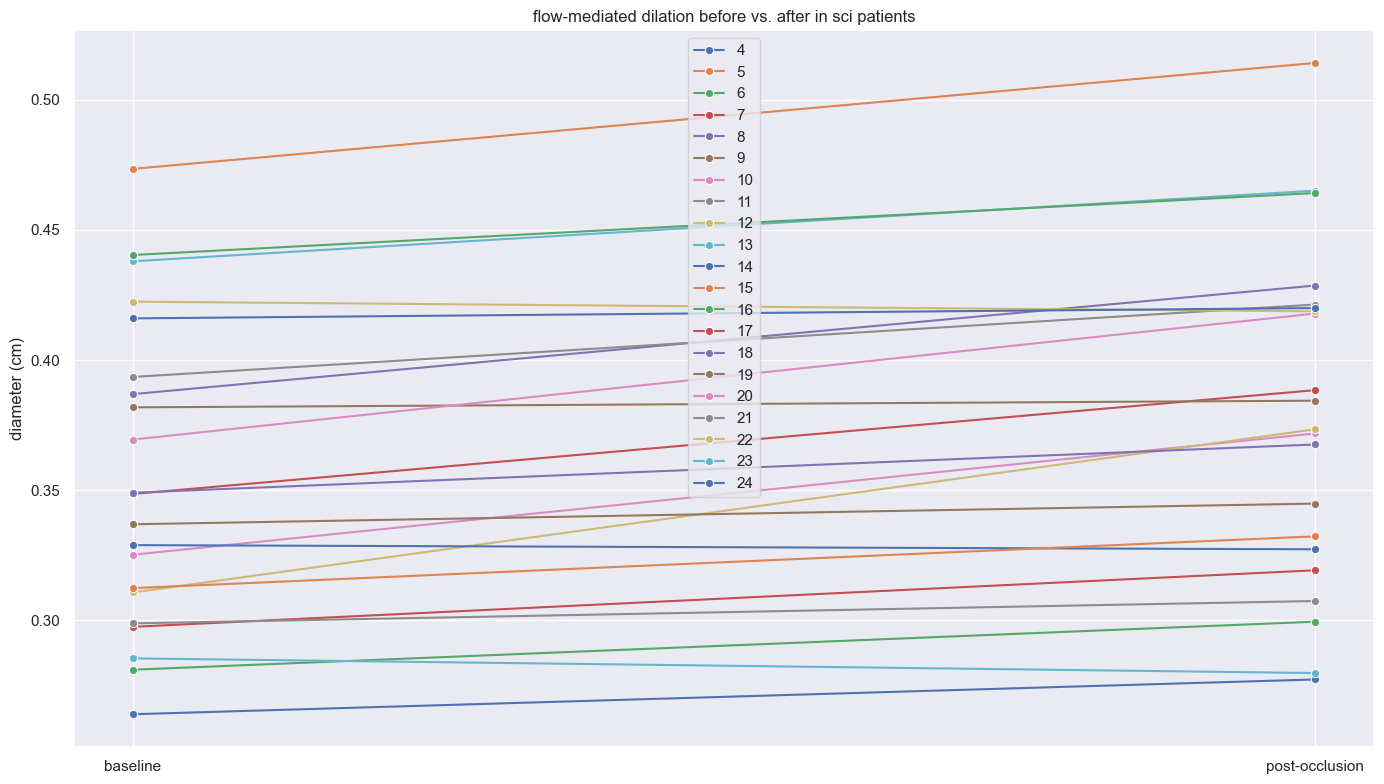

In [106]:
fmds = np.column_stack([baseline_fmd, post_fmd])

for fmd_pair, subj_num in zip(fmds, subj_numbers):
    sns.lineplot(x = [0,1], y = fmd_pair, marker = 'o', label = subj_num)

plt.title("flow-mediated dilation before vs. after in sci patients")
plt.ylabel("diameter (cm)")
plt.xticks([0,1],["baseline", "post-occlusion"])
plt.tight_layout()
plt.show()

# Control Loading Data

In [107]:
subj_numbers = list(range(1,15))
exclude = []

In [108]:
baseline_fmd = []
post_fmd     = []

for i, subj_num in enumerate(subj_numbers):
    subj_name = f"ASCI1{subj_num:02}"
    
    if subj_num not in exclude:
        baseline_fmd.append( fmd_subject(subj_name, baseline=True, plot = False) )
        post_fmd.append(fmd_subject(subj_name, baseline=False, plot = False))
    else:
        print(f"Excluding: {subj_name}")
        
    if (post_fmd[-1] - baseline_fmd[-1]) / baseline_fmd[-1] < 0.05 :
        print(f"{subj_name}: {(post_fmd[-1] - baseline_fmd[-1]) / baseline_fmd[-1]}")
    
baseline_fmd = np.array(baseline_fmd)
post_fmd = np.array(post_fmd)

fmd_percent_control = (post_fmd - baseline_fmd) / baseline_fmd
baseline_diams_control = baseline_fmd.copy()
post_diams_control = post_fmd.copy()

ASCI106: 0.03099796516504941


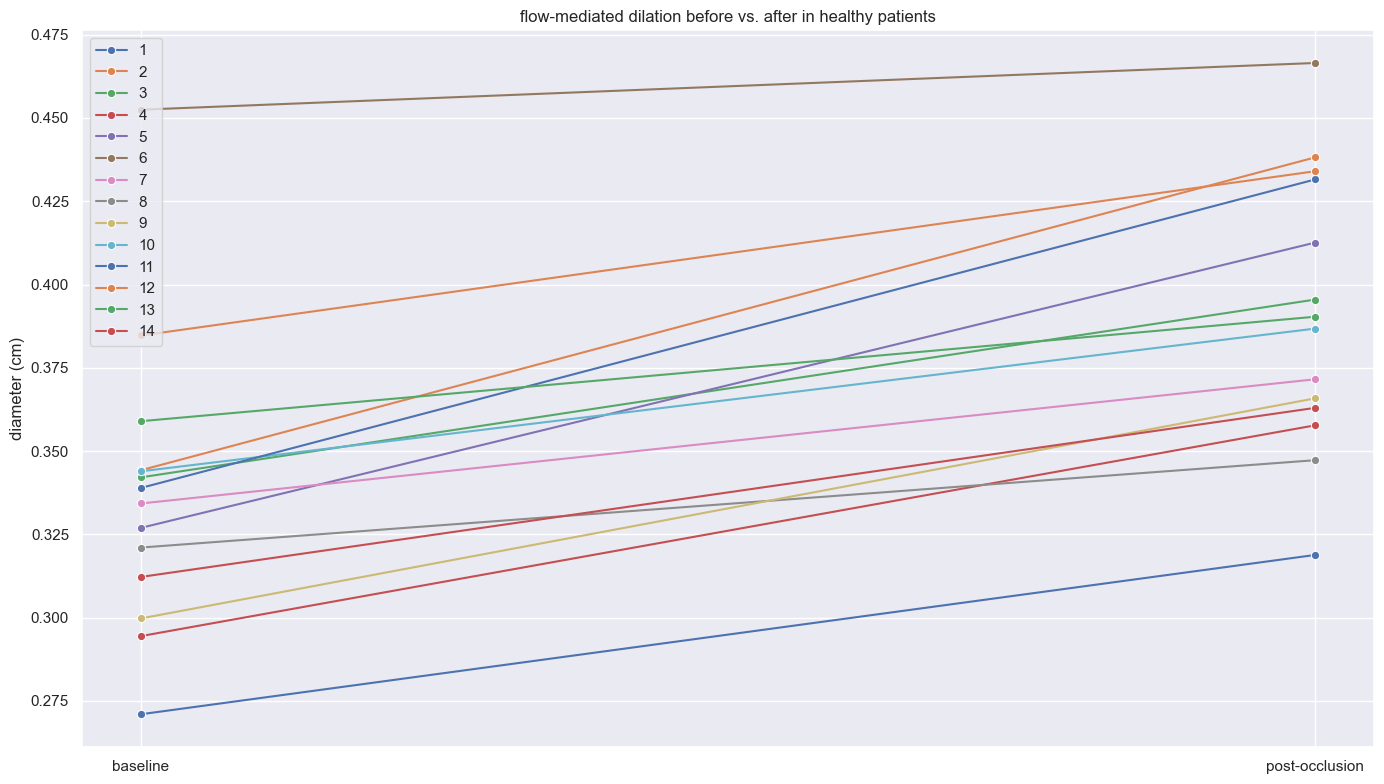

In [109]:
fmds = np.column_stack([baseline_fmd, post_fmd])

for fmd_pair, subj_num in zip(fmds, subj_numbers):
    sns.lineplot(x = [0,1], y = fmd_pair, marker = 'o', label = subj_num)

plt.title("flow-mediated dilation before vs. after in healthy patients")
plt.ylabel("diameter (cm)")
plt.xticks([0,1],["baseline", "post-occlusion"])
plt.tight_layout()
plt.show()

# Cross Comparison Plots and T-Test

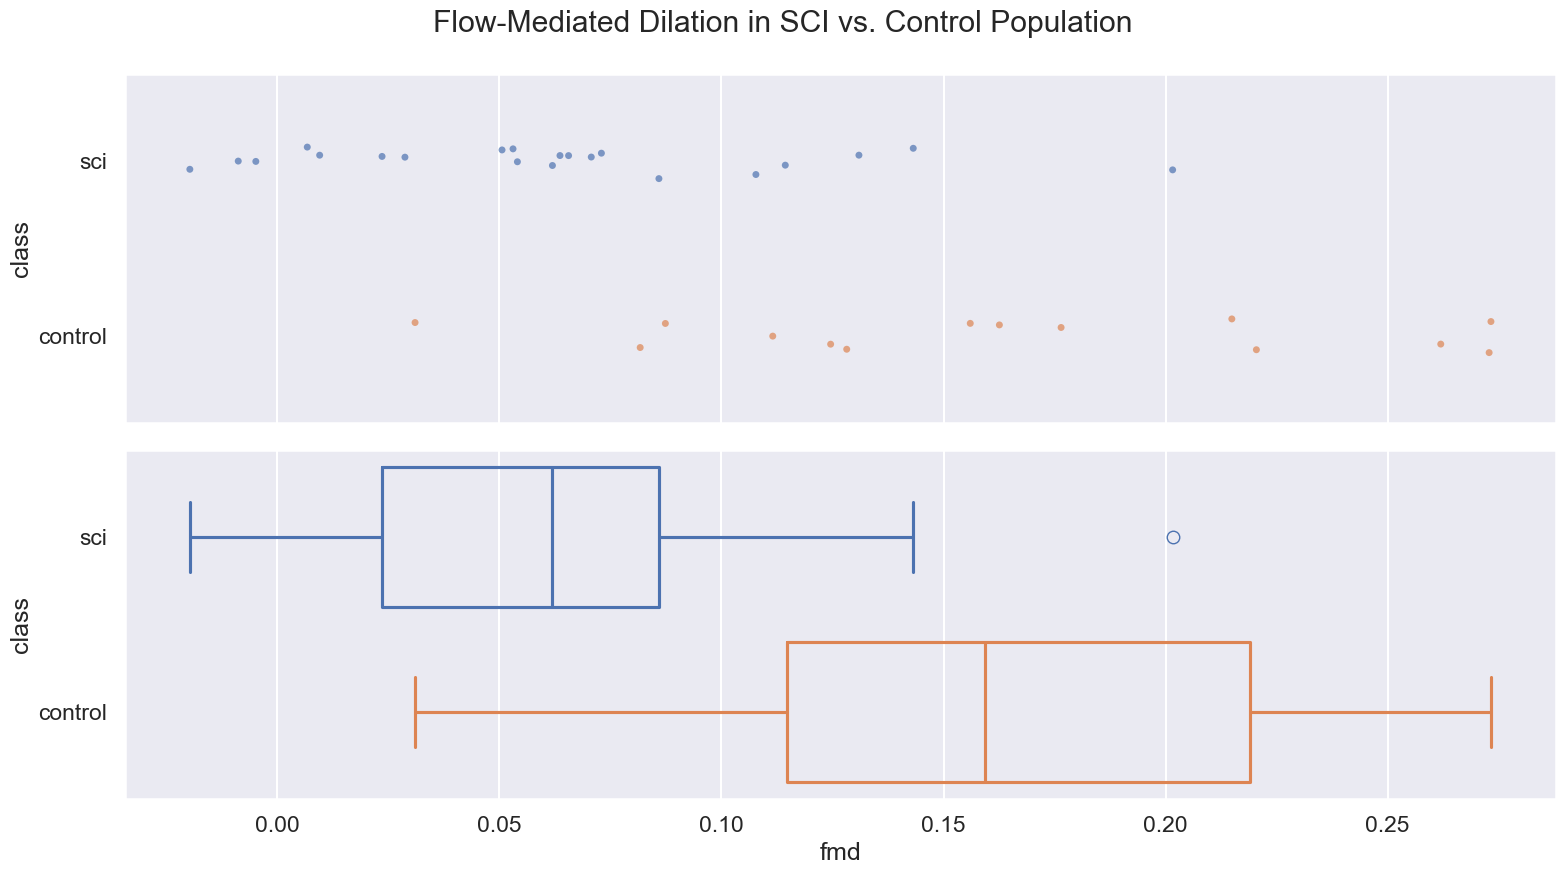

In [110]:
tags = ["sci"] * len(fmd_percent_sci) + ["control"] * len(fmd_percent_control)

sns.set_context("talk")
fig, ax = plt.subplots(2,1, sharey=True, sharex = True, figsize = (16,9))
plot_data = pd.DataFrame({"fmd": np.concatenate([fmd_percent_sci, fmd_percent_control]), "class" : tags})
sns.stripplot(data = plot_data, x = "fmd", y = "class", hue="class", alpha = 0.7, ax = ax[0])
sns.boxplot(data = plot_data, x = "fmd", y = "class", hue="class", fill=None, ax = ax[1])
plt.suptitle("Flow-Mediated Dilation in SCI vs. Control Population")
plt.tight_layout()

In [111]:
sp.stats.ttest_ind(fmd_percent_sci, fmd_percent_control)

TtestResult(statistic=-4.59732371655999, pvalue=6.011757697108138e-05, df=33.0)

# Saving Baseline diameters to csv for use in shear analysis

In [112]:
subj_diams = pd.DataFrame()

sci_nums = list(range(4,25))
control_nums = list(range(1,15))

name = lambda num, sci: f"ASCI{num:03}" if sci else f"ASCI1{num:02}"

sci_names = [name(num, True) for num in sci_nums]
control_names = [name(num, False) for num in control_nums]
names = sci_names + control_names
subj_diams['subject'] = names
subj_diams['baseline diameter'] = np.concatenate([baseline_diams_sci, baseline_diams_control])
subj_diams['post-occlusion diameter'] = np.concatenate([post_diams_sci, post_diams_control])
subj_diams['fmd'] = np.concatenate([fmd_percent_sci, fmd_percent_control])
subj_diams['class'] = ['sci'] * len(sci_nums) + ['control']*len(control_nums)
subj_diams

,subject,baseline diameter,post-occlusion diameter,fmd,class
0,ASCI004,0.263999,0.277353,0.050582,sci
1,ASCI005,0.473380,0.514048,0.085910,sci
2,ASCI006,0.281096,0.299526,0.065567,sci
3,ASCI007,0.348563,0.388427,0.114365,sci
4,ASCI008,0.386901,0.428589,0.107748,sci
5,ASCI009,0.381821,0.384390,0.006728,sci
6,ASCI010,0.325234,0.371801,0.143179,sci
7,ASCI011,0.393493,0.421303,0.070676,sci
8,ASCI012,0.310753,0.373397,0.201588,sci
9,ASCI013,0.437899,0.465018,0.061932,sci


# Adding in the times at which the peak dilation is reached

In [113]:
post_delay = pd.read_csv('diameter_time_alignment.csv').iloc[3:]
post_delay.reset_index(inplace= True, drop = True)
post_delay

,ASCI#,post occ delay
0,ASCI004,44.0
1,ASCI005,45.0
2,ASCI006,52.0
3,ASCI007,45.0
4,ASCI008,50.0
5,ASCI009,64.0
6,ASCI010,40.0
7,ASCI011,45.0
8,ASCI012,37.0
9,ASCI013,45.0


In [114]:
def get_time(subj_file):
    beginning = str.rfind(subj_file[0], ' ') +1
    time = subj_file[0][beginning+8:]
    hours = int(time[:2])
    mins = int(time[2:4])
    seconds = int(time[4:6])
    miliseconds = float(f"0.{time[6:]}")
    
    time  = (hours*60*60) + mins*60 + seconds + miliseconds
    
    return time

def align_time(subj_data, subj_file, baseline_file = False):
    if subj_file[1] in ['diameter', 'diam']:
        def get_video_fps(subj_file):
            def diam_video_file(subj_file):
                beginning = str.rindex(subj_file[0], '/') + 1
                filename = "raw_video/" + subj_file[0][beginning:] + ".avi"
                return filename
        
            diam_video_file(subj_file)
            video = cv.VideoCapture(diam_video_file(subj_file))
            fps = video.get(cv.CAP_PROP_FPS)
            return 1 / fps
        subj_data['time'] = subj_data.index.values * get_video_fps(subj_file)
        
        # if baseline_file != False:
        #     subj_data['time'] += (get_time(subj_file) - get_time(baseline_file))
        
    elif subj_file[1] in ['time', 'time_series', 'time series']: 
        if baseline_file != False:
            subj_data['Time'] += (get_time(subj_file) - get_time(baseline_file))
        else:
            raise ValueError("To align time series data, a baseline file must be provided.")

In [115]:
def arterial_peak_subject(subj_name: str):
    diameter = None
    baseline = subj_file(subj_name, 'baseline', 'diam')
    post =subj_file(subj_name, 'post', 'diam')
    post_diameter = load(post)
        
    diameter = filter_diameter(post_diameter)
    
    peaks = get_peaks(diameter = diameter, baseline = False, plot = False)

    align_time(subj_data = diameter, subj_file = post, baseline_file = baseline)
    
    return diameter.iloc[peaks]['time'].mean()


In [116]:
subj_diams['arterial peak time'] = subj_diams['subject'].apply(arterial_peak_subject) + post_delay['post occ delay']
subj_diams

,subject,baseline diameter,post-occlusion diameter,fmd,class,arterial peak time
0,ASCI004,0.263999,0.277353,0.050582,sci,54.766743
1,ASCI005,0.473380,0.514048,0.085910,sci,102.096656
2,ASCI006,0.281096,0.299526,0.065567,sci,72.260048
3,ASCI007,0.348563,0.388427,0.114365,sci,50.833787
4,ASCI008,0.386901,0.428589,0.107748,sci,65.795438
5,ASCI009,0.381821,0.384390,0.006728,sci,85.843417
6,ASCI010,0.325234,0.371801,0.143179,sci,79.521432
7,ASCI011,0.393493,0.421303,0.070676,sci,60.404403
8,ASCI012,0.310753,0.373397,0.201588,sci,54.875781
9,ASCI013,0.437899,0.465018,0.061932,sci,97.270583


Text(0.5, 0, 'flow-mediated dilation')

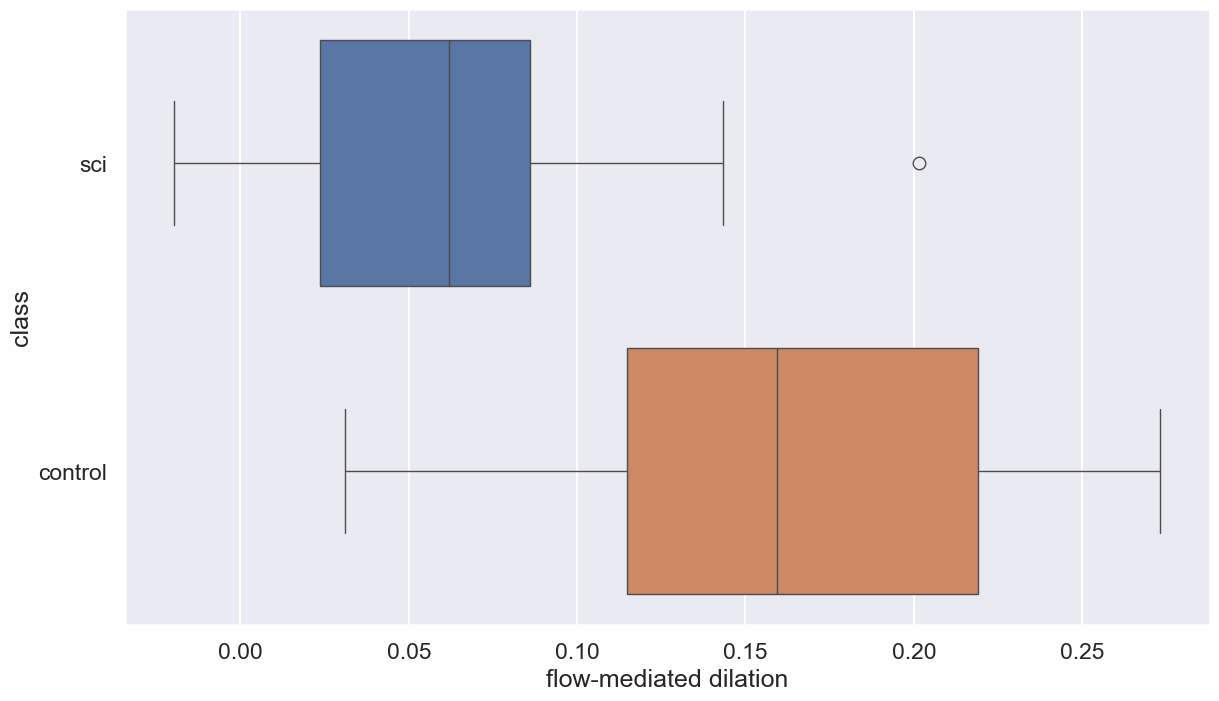

In [117]:
sns.boxplot(data = subj_diams, x = 'fmd', y = 'class', hue = 'class')
sp.stats.ttest_ind(subj_diams[subj_diams['class'] == 'sci']['fmd'], subj_diams[subj_diams['class'] == 'control']['fmd'])
plt.xlabel("flow-mediated dilation")

In [118]:
subj_diams[subj_diams['class'] == 'sci']['fmd'].mean() * 100, subj_diams[subj_diams['class'] == 'sci']['fmd'].std() * 100

(6.2444360678374125, 5.534954487693144)

In [119]:
subj_diams[subj_diams['class'] == 'control']['fmd'].mean() * 100, subj_diams[subj_diams['class'] == 'control']['fmd'].std() * 100

(16.449085299500315, 7.611028239376154)

TtestResult(statistic=3.1752467134208664, pvalue=0.0032374827637533057, df=33.0)

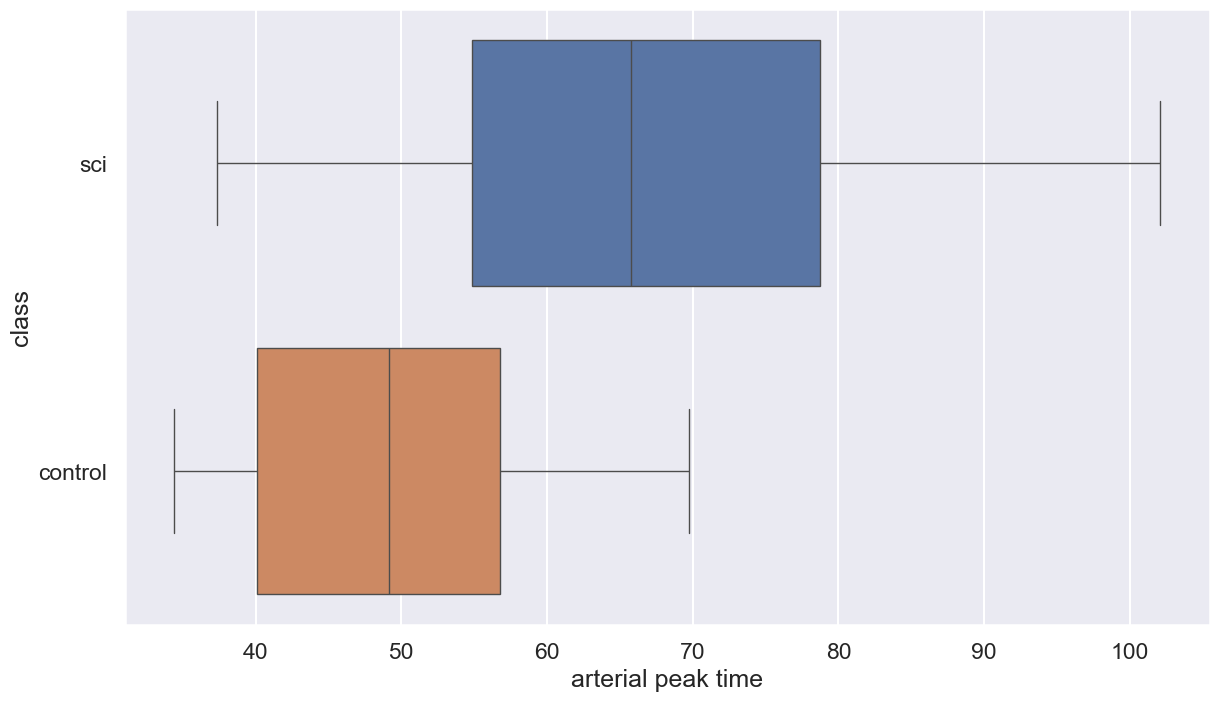

In [120]:
sns.boxplot(data = subj_diams, x = 'arterial peak time', y = 'class', hue = 'class')
sp.stats.ttest_ind(subj_diams[subj_diams['class'] == 'sci']['arterial peak time'], subj_diams[subj_diams['class'] == 'control']['arterial peak time'])

# Saving all data to CSV

In [121]:
subj_diams.to_csv('fmd_data.csv', index= False)